In [2]:
import numpy
from cadet import H5
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt

In [3]:
curdir = Path().absolute()  # get current directory

# Load training dataset
sim_file1 = H5()    # create h5 object for the simulation data of the first experiment
sim_file1.filename = Path('datagen_0OD_27mA/20250519-110946-8_param_datagen_0OD_27mA_30_merged.h5') # find filepath for this spectrum in any of the current subfolders and set as h5 filename
sim_file1.load()    # load simulation data
sim_file2 = H5()    # create h5 object for the simulation data of the second experiment
sim_file2.filename = Path('datagen_0OD_63mA/20250519-110946-8_param_datagen_0OD_63mA_30_merged.h5') # find filepath for this spectrum in any of the current subfolders and set as h5 filename
sim_file2.load()    # load simulation data
sim_file3 = H5()    # create h5 object for the simulation data of the third experiment
sim_file3.filename = Path('datagen_0OD_149mA/20250519-110946-8_param_datagen_0OD_149mA_30_merged.h5') # find filepath for this spectrum in any of the current subfolders and set as h5 filename
sim_file3.load()    # load simulation data
sim_file4 = H5()    # create h5 object for the simulation data of the fourth experiment
sim_file4.filename = Path('datagen_0OD_365mA/20250519-110946-8_param_datagen_0OD_365mA_30_merged.h5') # find filepath for this spectrum in any of the current subfolders and set as h5 filename
sim_file4.load()    # load simulation data
input = sim_file1.root.Input    # extract dictionary with all the input information for the training data simulation run
n_var = sim_file1.root.Input['n_var']   # extract number of variable parameters from input dictionary
print(input["var_param"])

par_mat = sim_file1.root.par_mat    # extract the parameter matrix with the parameter combinations used for the simulations
par_mat_ln = sim_file1.root.par_mat_ln  # extract parameter matrix with logarithm of parameters varied on a log-scale
# input = sim_file2.root.Input    # extract dictionary with all the input information for the training data simulation run

sim_1 = sim_file1.root.jv_sim   # extract jv curves for the first experiment [V, A/m²]
sim_2 = sim_file2.root.jv_sim   # extract jv curves for the second experiment [V, A/m²]
sim_3 = sim_file3.root.jv_sim   # extract jv curves for the third experiment [V, A/m²]
sim_4 = sim_file4.root.jv_sim   # extract jv curves for the fourth experiment [V, A/m²]
sim_x = sim_file1.root.vol_swp          # x-axis of experiment, here voltage [V]
# sim_x2 = sim_file2.root.vol_swp          # x-axis of experiment, here voltage [V]

lb = sim_file1.root.lb  # extract lower boundary for variable parameters
ub = sim_file1.root.ub  # extraqt upper boundary for variable parameters


[b'phibf' b'phibb' b'eg_abs1' b'suns' b'mue_abs1' b'muh_abs1'
 b'dosdb_abs1' b'kr_abs1']


In [4]:
def interp(X, Y, len):
    '''
    interp : interpolate function to interpoate data to required length
           
    Parameters 
    ----------
    x : numpy.array of old x axis
    y : numpy.array of y-axis values to be interpolated. Can contain multiple sets of data along the axis 0
    len: desired length of interpolated data

    returns
    -------
    y_inter : interpolated y values
    X_new : new a axis with length len
    '''
    X_new = numpy.linspace(X[0],X[-1],len) # create new x axis with desired number of points
    y_inter = numpy.zeros([Y.shape[0],len])   # preallocated interpolated y axis
    for idx in range(Y.shape[0]):   # loop through all elements of y that are to be interpolated
        func = Y[idx,:] # extract current element of y
        s = interpolate.InterpolatedUnivariateSpline(X,func,ext=1) # define interpolation object for the element and old x axis
        y_inter[idx,:] = s(X_new)   # interpolate with new x axis 
    return y_inter, X_new

In [5]:
def shiftQuadrant(Ylin):
    '''
    shiftQuadrant : function to shift the JV-curve into the first quandrant and plot it logarithmically
           
    Parameters 
    ----------
    Ylin : numpy.array of y-axis values on linear scale. Can contain multiple sets of data along the axis 0
    len: desired length of interpolated data

    returns
    -------
    Ysc_log : y axis intercepts of Ylin on a logarithmic scale
    Ylog : logarithm of Ylin shifted into the first quadrant by Ysc
    Ydiff : difference between first and last point of Ylog
    '''
    Ysc = Ylin[:,0] # [A/m²], y axis intercept of data. only possible if x axis starts at 0!!!
    Ysc_log = numpy.log(numpy.abs(Ysc)) # logarithm of y axis intercept
    Ylog = numpy.zeros([Ysc.shape[0],Ylin.shape[1]-1])  # preallocate array
    Ydiff = numpy.zeros((Ysc.shape[0],1)) # preallocate array
    for idx in range(Ysc.shape[0]): # loop through number of measurements in Ylin
        Ylog[idx,:] = numpy.log(numpy.abs(Ylin[idx, 1:] - Ysc[idx]))    # shift Ylin by y axis intercept and take logarithm
        if numpy.any(Ylog[idx,:]<-30):
            Ylog[idx,numpy.where(Ylog[idx,:]<-30)] = Ylog[idx,numpy.where(Ylog[idx,:]<-30)[0][-1]+1]
        Ydiff[idx,0] = Ylog[idx,-1] - Ylog[idx,0] # calculate difference between first and last point of Ylog
    return Ysc_log, Ylog, Ydiff

In [6]:
# take logarithmic value of current density in JV data

Jsc_1, sim_1_log, Jdiff_1 = shiftQuadrant(sim_1)
Jsc_2, sim_2_log, Jdiff_2 = shiftQuadrant(sim_2)
Jsc_3, sim_3_log, Jdiff_3 = shiftQuadrant(sim_3)
Jsc_4, sim_4_log, Jdiff_4 = shiftQuadrant(sim_4)

In [7]:
# interpolate data 
# output of NN is 512 and we have 4 light intensities. 
# Hence we divide the output space into 4 segments of len = 128 for each experiment

len = 128

sim_1_i_log, sim_x_i = interp(sim_x[1:], sim_1_log, len)
sim_2_i_log, sim_x_i = interp(sim_x[1:], sim_2_log,  len)
sim_3_i_log, sim_x_i = interp(sim_x[1:], sim_3_log,  len)
sim_4_i_log, sim_x_i = interp(sim_x[1:], sim_4_log,  len)


In [8]:
def extendJsc(Jsc, len):
    '''
    extendJsc : function to extend the Jsc values to full range of len
           
    Parameters 
    ----------
    Jsc : numpy.array of Jsc values for all experiments
    len : length of array for each experiment for the NN
    
    returns
    -------
    fullJsc : array with the same value repeated along the axis = 1 for the length len
    '''
    fullJsc = numpy.ones([Jsc.shape[0],len])    # preallocate array
    for idx in range(Jsc.shape[0]): # loop through all simulations
        fullJsc[idx,:] = fullJsc[idx,:] * Jsc[idx]  # fill entire row with the same Jsc value
    return fullJsc

In [9]:
# join the similar type of experiments
sim_i_log = numpy.column_stack((sim_1_i_log, sim_2_i_log, sim_3_i_log, sim_4_i_log)) # join all the shifted current densities
sim_x_i = numpy.concatenate((sim_x_i, sim_x_i, sim_x_i, sim_x_i)) # join all the voltages
sim_Jsc = numpy.column_stack((extendJsc(Jsc_1,1), extendJsc(Jsc_2,1), extendJsc(Jsc_3,1), extendJsc(Jsc_4,1))) # join all the Jsc

In [10]:
bad_idx = numpy.where(abs(sim_1[:,0])<abs(sim_1[:,1]))
bad_idx = numpy.concatenate((bad_idx,numpy.where(abs(sim_1[:,0])*0.9>abs(sim_1[:,1]))), axis = 1)
bad_idx = numpy.concatenate((bad_idx,numpy.where(abs(sim_2[:,0])<abs(sim_2[:,1]))), axis = 1)
bad_idx = numpy.concatenate((bad_idx,numpy.where(abs(sim_2[:,0])*0.9>abs(sim_2[:,1]))), axis = 1)
bad_idx = numpy.concatenate((bad_idx,numpy.where(abs(sim_3[:,0])<abs(sim_3[:,1]))), axis = 1)
bad_idx = numpy.concatenate((bad_idx,numpy.where(abs(sim_3[:,0])*0.9>abs(sim_3[:,1]))), axis = 1)
bad_idx = numpy.concatenate((bad_idx,numpy.where(abs(sim_4[:,0])<abs(sim_4[:,1]))), axis = 1)
bad_idx = numpy.concatenate((bad_idx,numpy.where(abs(sim_4[:,0])*0.9>abs(sim_4[:,1]))), axis = 1)
print(bad_idx)
print(numpy.shape(sim_Jsc))
for aa in bad_idx[0]:
    plt.plot(sim_i_log[aa,:])
    plt.show()
par_mat = numpy.delete(par_mat,bad_idx[0], axis = 0)
# par_mat_ln = numpy.delete(par_mat_ln,bad_idx[0], axis = 0)
sim_i_log = numpy.delete(sim_i_log,bad_idx[0], axis = 0)
sim_Jsc = numpy.delete(sim_Jsc,bad_idx[0], axis = 0)

[]
(30, 4)


In [11]:
def plot_sim(y_train, idx):
    '''
    plot_sim : function to plot selected simulation data with index idx
           
    Parameters 
    ----------
    y_train : numpy.array of simulated y data with multiple simulations along the axis = 0 
    idx : indices of the data that are supposed to be plotted
    '''
    count = numpy.size(idx) # define number of plots
    fig,ax = plt.subplots(count,1, figsize=[2*count,15]) # set figure 
    for i, num in enumerate(idx):  # loop through all indices
        ax[i,].plot(y_train[num,:]) # plot y values of specific index with arbitrary x axis
    plt.xlabel('voltage (a.u.)')
    plt.ylabel('current (a.u.)')
    plt.show()

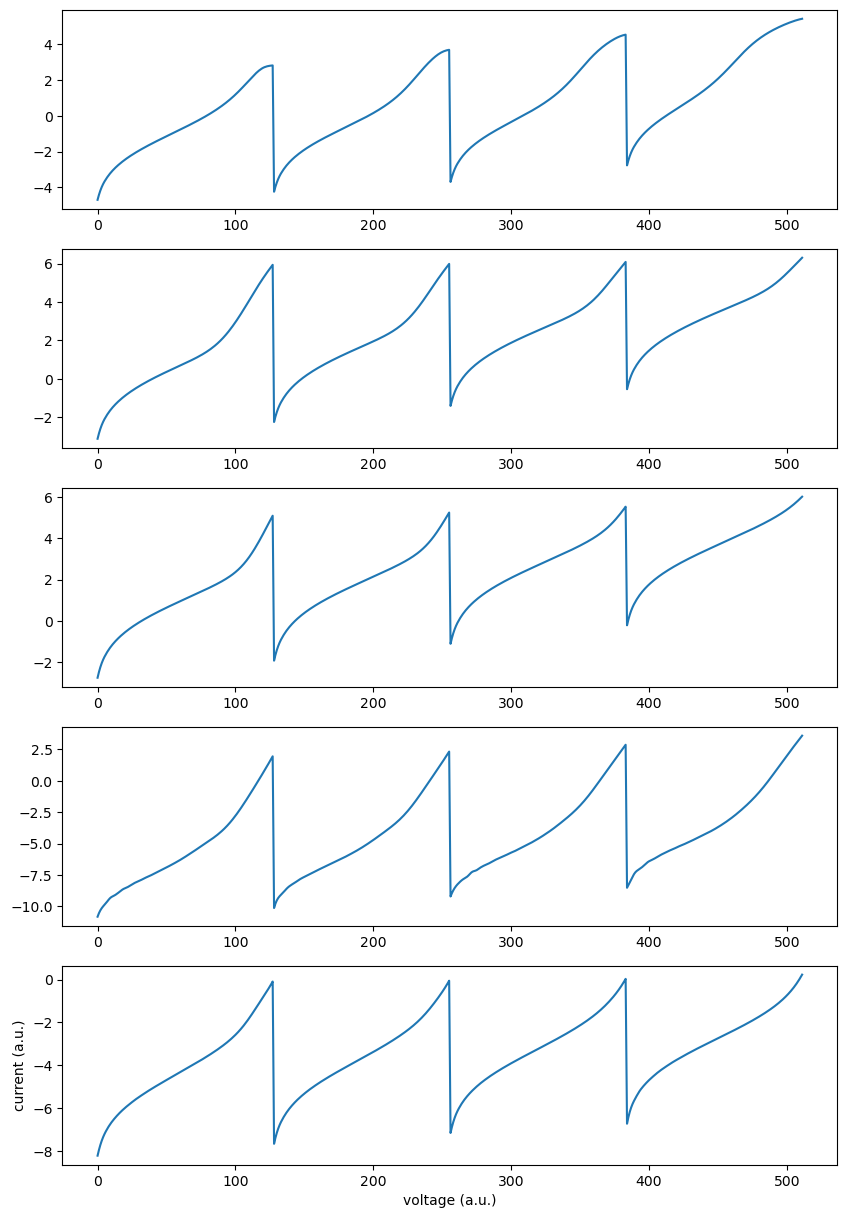

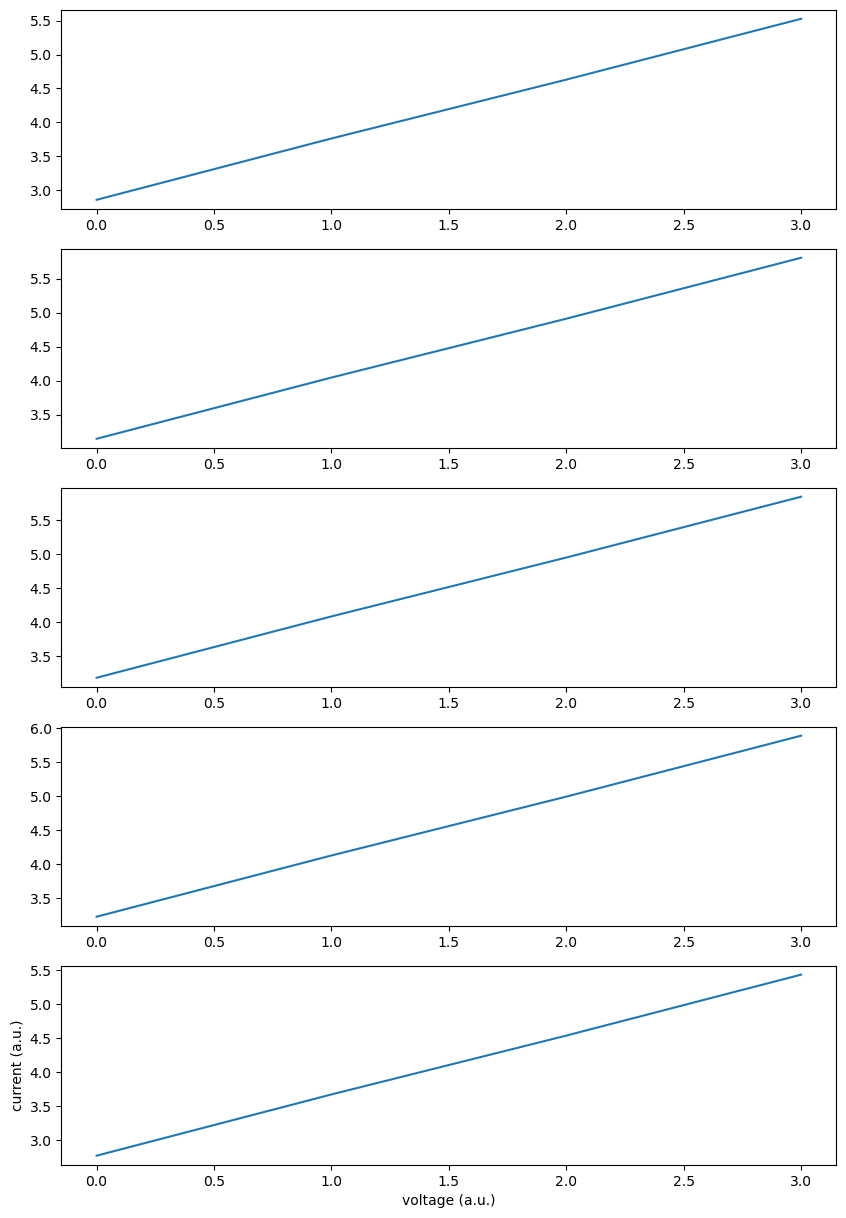

In [12]:
# generate random 5 number to plot various graphs
idx = numpy.random.randint(0, par_mat.shape[0],5)
plot_sim(sim_i_log, idx)
# plot_sim(sim_i_log_R,idx)
plot_sim(sim_Jsc, idx)

In [13]:
def output_transform(x):
    '''
    output_transform : Function to perform transformation of the output vectors into the space (0 to 1) req
    uired by the Neural Network
           
    Parameters 
    ----------
    x : numpy.array to be normalized
    
    returns
    -------
    output_norm : array normalized between 0 and 1 
    max : maximum of x in all dimensions
    min : minimum of x in all dimensions
    '''
    min = (numpy.nanmin(x)) # find minimum of array ignoring NaNs in all dimensions
    max = (numpy.nanmax(x)) # find maximum of array ignoring NaNs in all dimensions
    output_norm = (x-min)/(max-min) # normalize x between its maximum and minimum
    return output_norm,max,min

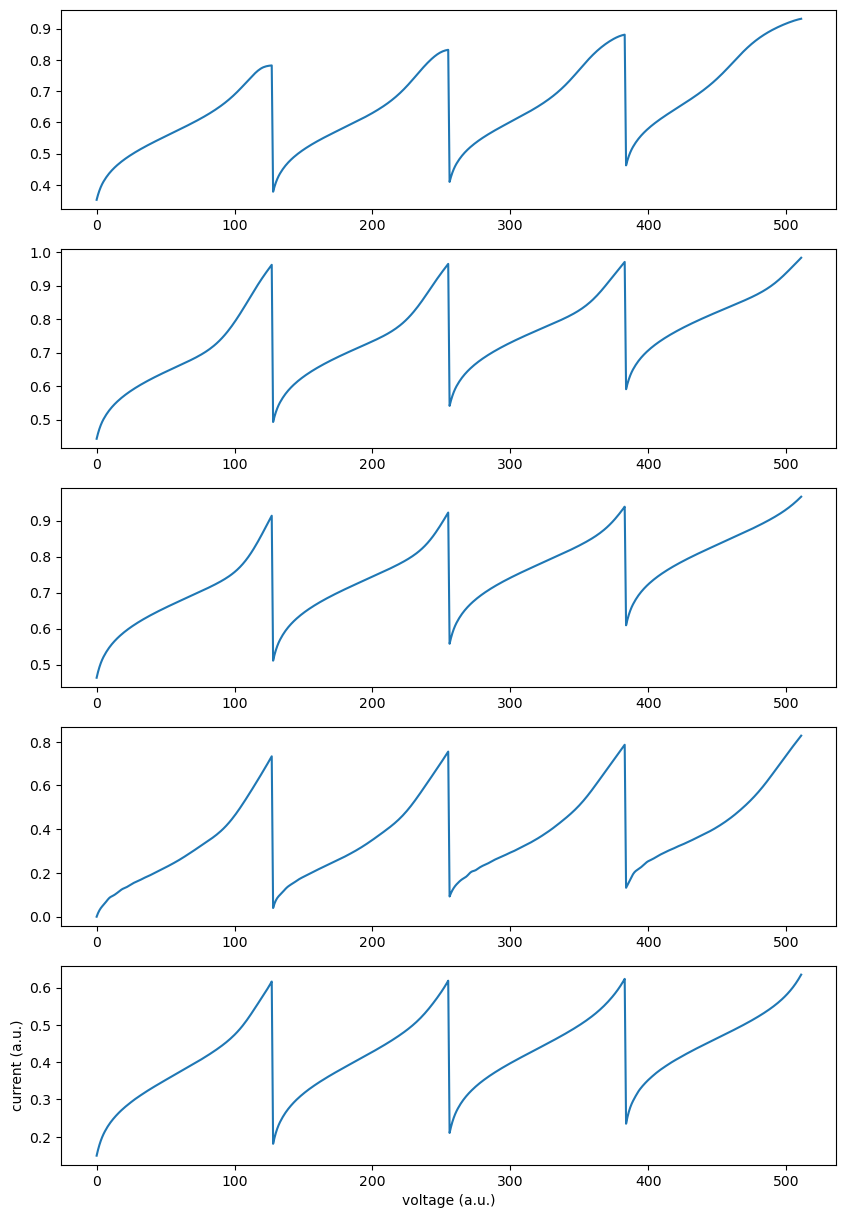

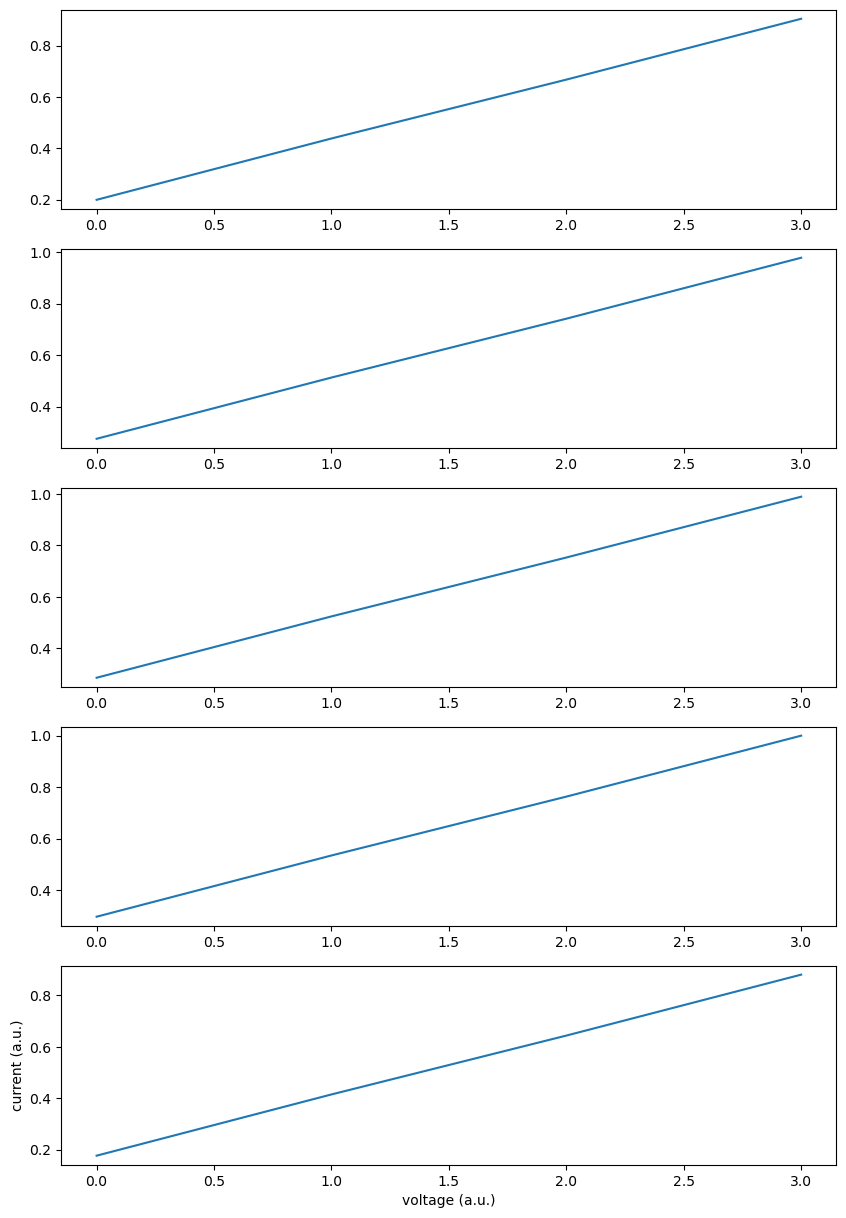

In [14]:
# normalize training data between 0 and 1 
sim_JV_norm, sim_JV_max, sim_JV_min = output_transform(sim_i_log) 
sim_Jsc_norm, sim_Jsc_max, sim_Jsc_min = output_transform(sim_Jsc) 
# plot normalized data
plot_sim(sim_JV_norm, idx)
plot_sim(sim_Jsc_norm, idx)


In [18]:
# store normalized data
norm_data = H5()    # create h5 object for normalized data
new_directory = Path(str(curdir).split("Datagen")[0] + 'Dataset')
if not new_directory.exists():
    new_directory.mkdir()
FN =  str(new_directory) + '/' + sim_file1.filename.name.split('_datagen')[0]  + '_norm.h5' # modify training data filename 
norm_data.filename = Path(FN)   # set modified filename as path for h5 object

# store the individual shifted JV curves in h5 object
norm_data.root.Y1_single = sim_1_i_log
norm_data.root.Y2_single = sim_2_i_log
norm_data.root.Y3_single = sim_3_i_log
norm_data.root.Y4_single = sim_4_i_log
norm_data.root.Y_all = sim_i_log

norm_data.root.Y1_norm = sim_JV_norm    # save normalized, joint, shifted JV curve
norm_data.root.Y1_max = sim_JV_max  # save maximum of first data set 
norm_data.root.Y1_min = sim_JV_min  # save minimum of first data set 
norm_data.root.X1 = sim_x_i # save interpolated x axis
norm_data.root.X1 = sim_x   # save original x axis

norm_data.root.Y2_norm = sim_Jsc_norm   # save normalized, joint logarithm of Jsc
norm_data.root.Y2_max = sim_Jsc_max # save maximum of second data set
norm_data.root.Y2_min = sim_Jsc_min # save minimum of second data set 

# copy corresponding parameter matrices
norm_data.root.par_mat = par_mat 
norm_data.root.par_mat_ln = par_mat_ln

norm_data.root.Input = input    # conpy simulation input dictionary into new h5 object

norm_data.save()    # save h5 file